# Prepare synthetic data

- Zella King
- 2022-09-30

Our goal is to develop a Bayesian model to predict a patient's probability of being discharged in the next 24 hours. 

Here are three initial steps I think we need to do: 

 1. Decide on our "prior" probability and express it as a distribution 
 2. Identify some data we can use for the "likelihood". This can be synthetic to start with
 3. Develop a posterior distribution from the prior and likelihood. 

 In this example I'm using terminology and  methods from here: https://allendowney.github.io/ThinkBayes2/chap06.html

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import poisson, lognorm
import sqlalchemy as sa

In [2]:
%matplotlib inline

## Prior odds

Previously we found, by interrogating some synthetic data, that a patient's probability of discharge in the next 24 hours was .1111. Let's call this a probability of 1/9

We could express this as odds. For everyone 1 patient discharged, 8 remain. Therefore the odds of discharge are 1:8 or 0.125. 


In [3]:
def odds(p):
    return p / (1-p)

odds (1/9)

def prob(o):
    return o / (o+1)

## Likelihood


In probability form, Bayes theorem is this:

$ P(H | D) =\frac{P(H)P(D|H)}{P(D)}$

It can be rewritten in terms of odd (Bayes rule).  We can express the odds in favour of discharge as:

$ odds(discharge | data) =odds (discharge) * \frac{P( data | discharge)}{P( data | not discharged)}$

We will read in the dummy data to get the likelihood. Note that this table of synthetic data has been adjusted to make it more likely that older people have a longer time to discharge

In [9]:
sqlite_engine = sa.create_engine('sqlite:///../../data/dummy.db')
df = pd.read_sql_query("SELECT id, hours_to_discharge, department, age, pulse from discharges_age_adjusted", sqlite_engine)

# Let N be the number of patients observed
N = df.shape[0]

# Let X be the number of patients who were discharged in 24 hours
X = df[df.hours_to_discharge <= 24].shape[0]
print("Number of people discharged in 24 hours: " + str(X))
print("Total number of people observed: " + str(N))

Number of people discharged in 24 hours: 32
Total number of people observed: 444


Let's group age into two categories (over 65 or not) and identify which ones were actually discharged in 24 hours. Then, cross-tabulating them:

In [10]:
df

,id,hours_to_discharge,department,age,pulse
0,0,36.000000,UCH T07 SOUTH,35.0,78.0
1,1,456.573401,UCH T14 NORTH TRAUMA,60.0,98.0
2,2,NaN,UCH T10 SOUTH (T10S),70.0,76.0
3,3,17.000000,UCH T11 SOUTH (T11S),55.0,104.0
4,4,NaN,UCH T01 ACUTE MEDICAL,35.0,68.0
...,...,...,...,...,...
439,439,NaN,UCH T06 HEAD (T06H),70.0,74.0
440,440,NaN,UCH SDEC,35.0,76.0
441,441,213.938412,UCH T16 SOUTH WINTER,65.0,NaN
442,442,346.482699,UCH T12 NORTH (T12N),60.0,55.0


In [11]:
df['agegp'] = df['age'].apply(lambda x:  'gt65' if x>65 else 'lte65')
df['dischargein24'] = df.hours_to_discharge <= 24
pivot = df.groupby('agegp')['dischargein24'].value_counts().to_frame().rename(columns = {'dischargein24':'N'})
pivot.reset_index().pivot(columns = 'dischargein24', index = 'agegp', values = 'N')



dischargein24,False,True
agegp,,
gt65,179,6
lte65,233,26


## Posterior

Let's say we are looking at one patient of the 444 and this person is over 65. We want to know whether this person will be discharged in the next 24 hours. These posterior odds are given by this equation: 

$ odds(discharge | over65 ) =odds (discharge) * \frac{P( over65 | discharge)}{P( over65 | not discharged)}$



In [153]:
likelihood_gt65_given_dis = df[(df.dischargein24) & (df.agegp == 'gt65')].shape[0] / df[df.dischargein24].shape[0]
print(likelihood_gt65_given_dis)

0.1875


$ P( over65 | not discharged)$ is:

In [13]:
likelihood_lte65_given_dis = df[~(df.dischargein24) & (df.agegp == 'gt65')].shape[0] / df[~df.dischargein24].shape[0]
print(likelihood_lte65_given_dis)

0.4344660194174757


Likelihood ratio, given by $  \frac{P( over65 | discharge)}{P( over65 | not discharged)}$ is:

In [155]:
likelihood_gt65_given_dis/likelihood_lte65_given_dis

0.43156424581005587

In [157]:
prior_odds = 1/8
likelihood_ratio = likelihood_gt65_given_dis/likelihood_lte65_given_dis
print(likelihood_ratio)
post_odds = prior_odds * likelihood_ratio
post_odds

0.43156424581005587


0.053945530726256984

The posterior odds, given a patient is over 65 are substantially reduced 

## Using Allen Downey functions

In [141]:
bindex = ['prior']
table = pd.DataFrame(index = index)
table['odds'] = 1/8
table['prob'] = prob(table['odds'])
table

table

,odds,prob
lte65,0.125,0.111111
gt65,0.125,0.111111


In [142]:
index = ['lte65', 'gt65']
table = pd.DataFrame(index = index)
table['odds'] = 1/8
table['prob'] = prob(table['odds'])
table



,odds,prob
lte65,0.125,0.111111
gt65,0.125,0.111111


Adding the likelihood we computed earlier:

Calculating the posterior odds for both groups

In [143]:
table_ = table.reset_index().rename(columns= {'index': 'agegp'})


In [144]:
table_

,agegp,odds,prob
0,lte65,0.125,0.111111
1,gt65,0.125,0.111111


In [158]:
def get_lr(agegp_):
    l_dis = df[(df.dischargein24) & (df.agegp == agegp_)].shape[0] / df[df.dischargein24].shape[0]
    l_not_dis = df[~(df.dischargein24) & (df.agegp == agegp_)].shape[0] / df[~df.dischargein24].shape[0]
    lr = l_dis/l_not_dis
    return lr

table_['likelihood ratio'] = table_['agegp'].apply(lambda x: get_lr(x))
table_['posterior odds'] = table_['likelihood ratio']*table_['odds']
table_['posterior prob'] = prob(table_['posterior odds'])

In [159]:
table_

,agegp,odds,prob,likelihood ratio,posterior odds,posterior prob
0,lte65,0.125,0.111111,1.436695,0.179587,0.152246
1,gt65,0.125,0.111111,0.431564,0.053946,0.051184


In [130]:
agegp_ = 'lte65'
l_dis = df[(df.dischargein24) & (df.agegp == agegp_)].shape[0] / df[df.dischargein24].shape[0]
l_not_dis = df[~(df.dischargein24) & (df.agegp == agegp_)].shape[0] / df[~df.dischargein24].shape[0]
lr = l_dis/l_not_dis
lr

1.4366952789699572

## Now try a logistic regression

The posterior odds were expressed in this equation:

$ odds(discharge | over65 ) =odds (discharge) * \frac{P( over65 | discharge)}{P( over65 | not discharged)}$

$ \log odds(discharge | over65 ) = \log odds (discharge) + \log \frac{P( over65 | discharge)}{P( over65 | not discharged)}$


In [27]:
# from Allen Downey github here https://github.com/AllenDowney/ThinkBayes2/blob/master/soln/utils.py
def decorate(**options):
    """Decorate the current axes.
    
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
             
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)
    
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

# modified from https://allendowney.github.io/ThinkBayes2/chap16.html
    
def plot_data(data):
    """Plot damage as a function of temperature.
    
    data: DataFrame
    """
    plt.plot(data['age'], data['dischargein24'], 'o', 
             label='data', color='C0', alpha=0.4)

    decorate(ylabel="Discharged in 24 hours",
         xlabel="Age",
         title="Age by probability")

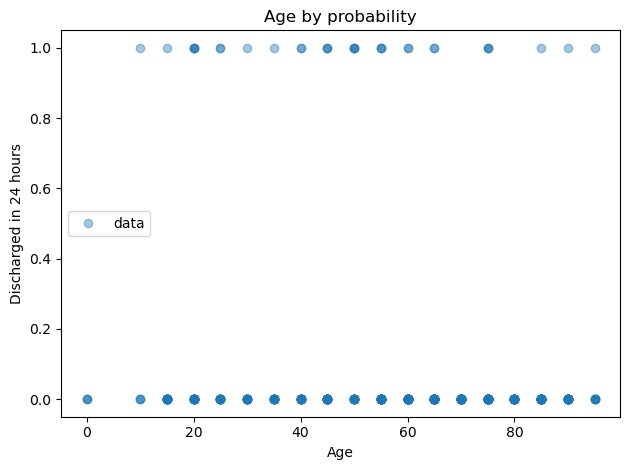

In [28]:
plot_data(df)

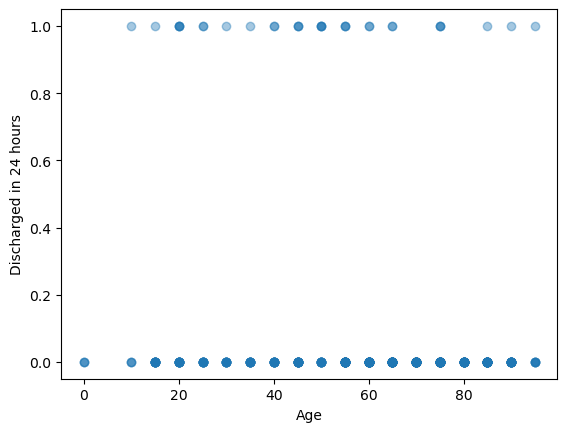

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.plot(df['age'], df['dischargein24'], 'o', 
            label='data', color='C0', alpha=0.4)

ax.set_ylabel('Discharged in 24 hours')
ax.set_xlabel('Age')

plt.show()




Based on this, there does not appear to be much of a relationship between age and probability of discharge. Nonetheless, let's assume this probability follows a logistic model. 

$ \log odds(discharge | over65 ) = \beta_{0} + \beta_{1} age $

In [14]:
age_offset = df['age'].mean().round()
df['x'] = df['age'] - age_offset
df['y'] = df['dischargein24'].apply(lambda x: 1 if x else 0)

import statsmodels.api as sm
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.logit(formula, data=df[['x', 'y']]).fit(disp=False)
results.params

Intercept   -2.659918
x           -0.021289
dtype: float64

We can use these parameters to compute probabilities for a range of ages. 

In [15]:
inter = results.params['Intercept']
slope = results.params['x']
xs = np.arange(53, 83) - age_offset

In [16]:
log_odds = inter + slope * xs

And then convert to probabilities

In [17]:
odds = np.exp(log_odds)
ps = odds / (odds + 1)

In [18]:
from scipy.special import expit

ps = expit(inter + slope * xs)

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(df['age'], df['dischargein24'], 'o', 
            label='data', color='C0', alpha=0.4)

ax.set_ylabel('Discharged in 24 hours')
ax.set_xlabel('Age')

plt.show()